# (21) mnist - mlp

**Motivation**: host = ```solo```, device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 0
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:0  ———  host: solo

## MNIST

- ```mlp``` decoder

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'jacob|mlp')

seq_len = 64

cfg_vae['track_stats'] = True
cfg_vae['seq_len'] = seq_len

cfg_tr['kl_beta'] = 8/16 * seq_len

### Make model + trainer

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    IPVAE    |  567.1 K   |
|     ———     |    ———     |
|    layer    |  567.1 K   |
+-------------+------------+

poisson_MNIST_t-64_z-[128]_<jacob|mlp>
b200-ep400-lr(0.002)_beta(32:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_22,09:15)

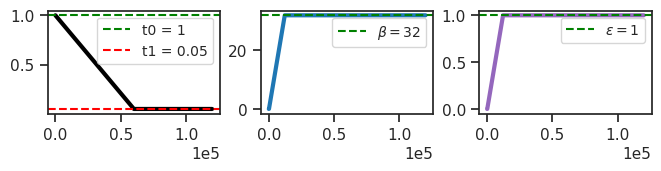

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
tr.n_iters

120000

In [7]:
print_num_params(tr.model.layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  567.1 K   |
|     ———      |    ———     |
|     dec      |  566.8 K   |
+--------------+------------+

In [8]:
tr.alphas, tr.alphas_time

(None, None)

In [9]:
print(tr.model.layer.dec)

Sequential(
  (0): Linear(in_features=128, out_features=256, bias=True)
  (1): SiLU(inplace=True)
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): SiLU(inplace=True)
  (4): Linear(in_features=512, out_features=784, bias=True)
)

In [10]:
print(f"{vars(tr.model.cfg)}\n\n\n{vars(tr.cfg)}")

{'prior_log_dist': 'uniform', 'clamp_prior': -2, 'hard_fwd': False, 'exc_only': False, 'type': 'poisson', 'n_ch': 
32, 'seq_len': 64, 'n_latents': [128], 'jac_type': 'grad', 'enc_type': 'jacob', 'dec_type': 'mlp', 'dataset': 
'MNIST', 'input_sz': (1, 28, 28), 'shape': (-1, 1, 28, 28), 'res_eps': 1.0, 'clamp_u': 8.0, 'clamp_du': 7.0, 
'init_dist': 'normal', 'init_scale': 0.05, 'activation_fn': 'swish', 'fit_prior': True, 'residual': True, 'use_bn':
False, 'use_se': True, 'track_stats': True, 'seed': 0, 'base_dir': '/home/hadi/Projects/PoissonVAE', 'data_dir': 
'/home/hadi/Datasets', 'runs_dir': '/home/hadi/Projects/PoissonVAE/runs/poisson_MNIST_t-64_z-[128]_<jacob|mlp>', 
'mods_dir': '/home/hadi/Projects/PoissonVAE/models/poisson_MNIST_t-64_z-[128]_<jacob|mlp>', 'results_dir': 
'/home/hadi/Projects/PoissonVAE/results'}


{'lr': 0.002, 'epochs': 400, 'batch_size': 200, 'file_name': None, 'warm_restart': 1, 'warmup_portion': 0.005, 
'optimizer': 'adamax_fast', 'scheduler_type': 'cosine', 'optimizer_kws': {'weight_decay': 0.0003, 'betas': (0.9, 
0.999), 'eps': 1e-08}, 'scheduler_kws': {'T_max': 132.66666666666666, 'eta_min': 1e-05}, 'ema_rate': None, 
'grad_clip': 50, 'chkpt_freq': 50, 'eval_freq': 20, 'log_freq': 10, 'method': 'mc', 'kl_beta': 32.0, 'kl_beta_min':
0.0001, 'kl_balancer': None, 'kl_time_adjuster': None, 'kl_anneal_cycles': 0, 'kl_anneal_portion': 0.1, 
'kl_const_portion': 0.001, 'temp_anneal_portion': 0.5, 'temp_anneal_type': 'lin', 'temp_start': 1.0, 'temp_stop': 
0.05}

### Fit model

In [11]:
tr.train()

epoch # 400, avg loss: 9.460922: 100%|██████| 400/400 [8:45:16<00:00, 78.79s/it]


**Task:** MNIST, $(T, \beta) = (64, 32.0)$, ```mlp``` decoder, z-128

In [12]:
print(tr.model.layer.n_exp)

tensor([16, 18, 21, 24, 28, 32, 35, 38, 41, 44, 46, 48, 50, 52, 53, 55, 56, 57,
        59, 60, 61, 62, 62, 63, 64, 65, 65, 66, 66, 67, 67, 67, 68, 68, 68, 69,
        69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70], device='cuda:0',
       dtype=torch.int32)

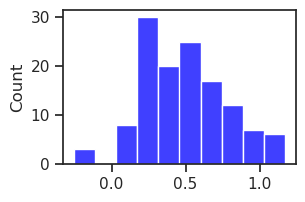

In [13]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
sns.histplot(log_rate, color='b');

In [14]:
## Was: linear decoder

In [22]:
dead = log_rate < 0
dead.sum()

3

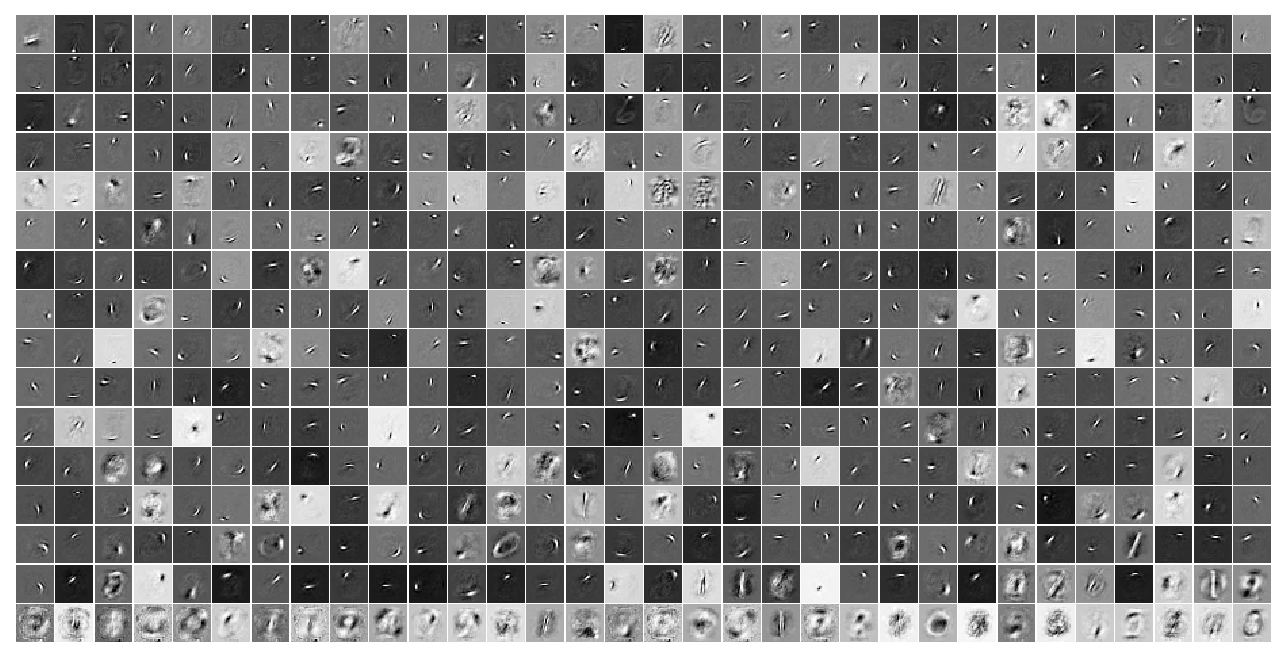

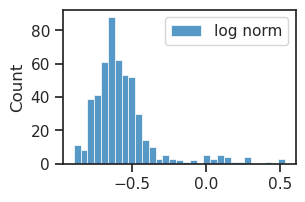

In [23]:
w = tr.model.layer.get_weight()
norms = tonp(torch.linalg.vector_norm(w, dim=1))

_ = tr.model.show(order=np.argsort(norms))

sns.histplot(np.log(norms), label='log norm')
plt.legend()
plt.show()

100%|█████████████████████████████████| 50/50 [23:36<00:00, 28.33s/it]


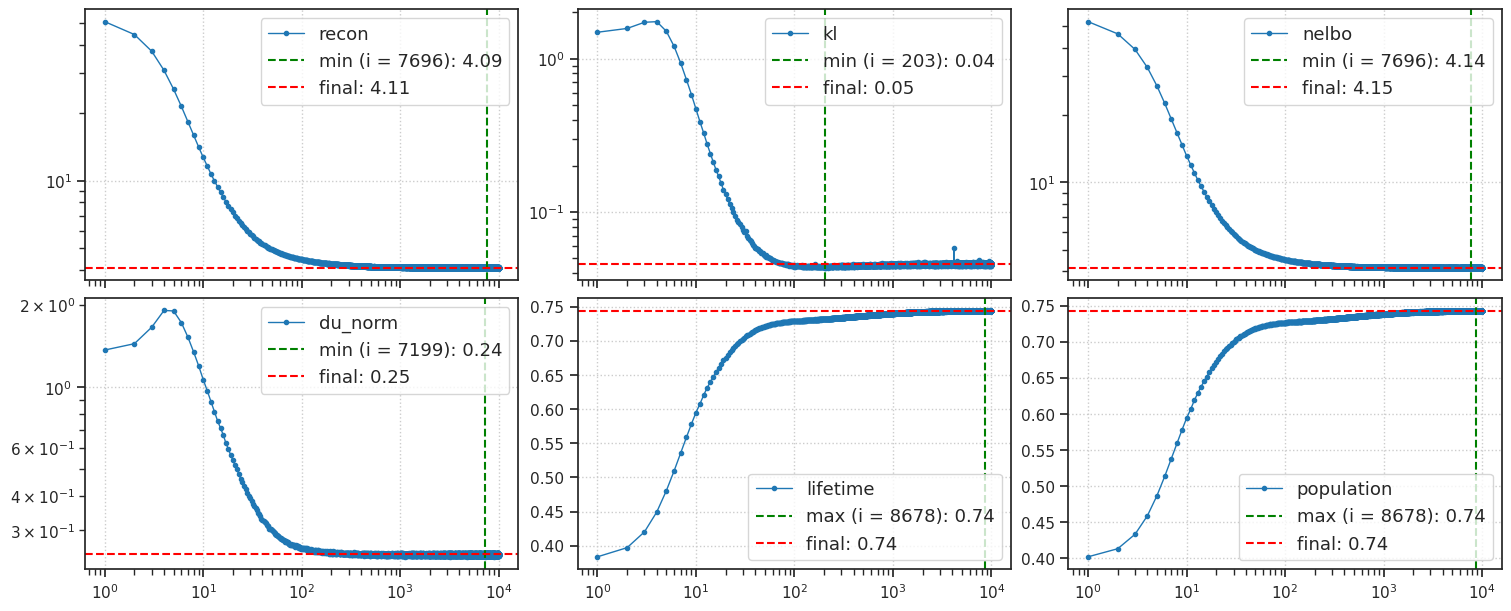

CPU times: user 23min 15s, sys: 39.4 s, total: 23min 54s
Wall time: 23min 52s


In [28]:
%%time

kws = dict(
    seq_total=10000,
    seq_batch_sz=1000,
    n_data_batches=None,
    active=~dead,
)
results = tr.analysis(**kws)
_ = plot_convergence(results, color='C0')

In [27]:
tr.model.cfg.dec_type, (tr.model.cfg.seq_len, tr.cfg.kl_beta)

('mlp', (64, 32.0))

In [ ]:
posterior_log_rates = collections.defaultdict(list)
for x, *_ in iter(tr.dl_vld):
    output = tr.model.xtract_ftr(x)
    for t, pois in output['dist'].items():
        posterior_log_rates[t].append(torch.log(pois.rate))
posterior_log_rates = {
    t: tonp(torch.cat(v)) for t, v
    in posterior_log_rates.items()
}


fig, ax = create_figure(1, 1, (10, 3.5))
pal = get_cubehelix_palette(tr.model.cfg.seq_len, start=2.5)

for i, (t, v) in enumerate(posterior_log_rates.items()):
    x2p = v.ravel()
    x2p = x2p[x2p > -10]
    sns.histplot(
        x2p,
        stat='percent',
        element='step',
        fill=False,
        color=pal[i],
        label=f"T = {t}",
        ax=ax,
    )
# ax.legend()
ax.grid()
plt.show()


fig, axes = create_figure(2, 1, (6, 4.2), sharex='col')
for i, (t, v) in enumerate(posterior_log_rates.items()):
    for ax in axes.flat:
        sns.histplot(
            np.exp(v.ravel()),
            stat='percent',
            element='step',
            fill=False,
            color=pal[i],
            label=f"T = {t}",
            ax=ax,
        )
axes[1].set(yscale='log')
add_grid(axes)
plt.show()

In [10]:
# model_name = 'gaussian_MNIST_t-10_z-[128]_<lin|lin>'
# fit_name = 'mc_b200-ep500-lr(0.002)_beta(5:0x0.5)_gr(1000)_(2024_09_06,15:58)'
# tr, meta = load_model(model_name, fit_name, device=device)
# meta['checkpoint']

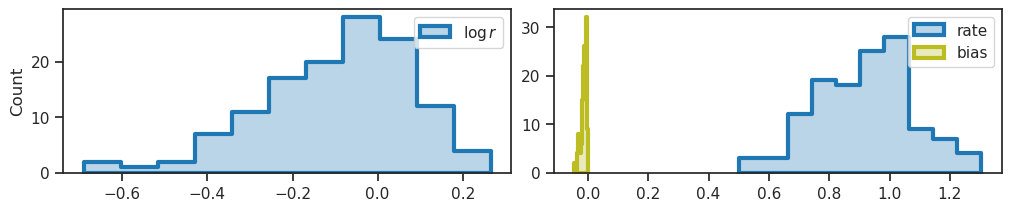

In [13]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
bias = tonp(tr.model.layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [15]:
dead = log_rate > 2
dead.sum(), (~dead).sum(), dead.sum() / len(dead)

(0, 128, 0.0)

In [16]:
%%time

kws = dict(
    seq_total=10000,
    seq_batch_sz=1000,
    n_data_batches=0,
    active=~dead,
    # full_data=True,
    # return_recon=False,
)
results = {
    name: tr.analysis(dl_name=name, **kws)
    for name in ['vld', 'trn'] # , 'tst']
}

100%|█████████████████████████████| 300/300 [1:50:05<00:00, 22.02s/it]


CPU times: user 2h 5min 45s, sys: 5min 40s, total: 2h 11min 25s
Wall time: 2h 13min 55s


______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

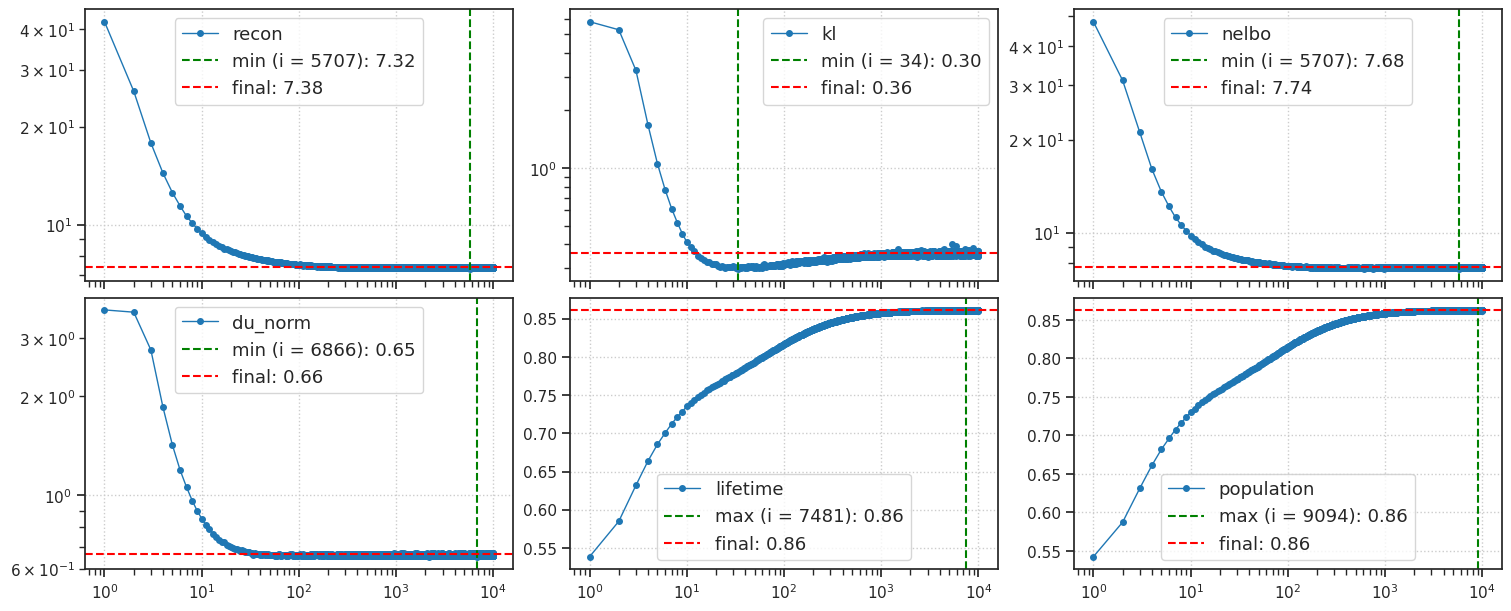

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

trn

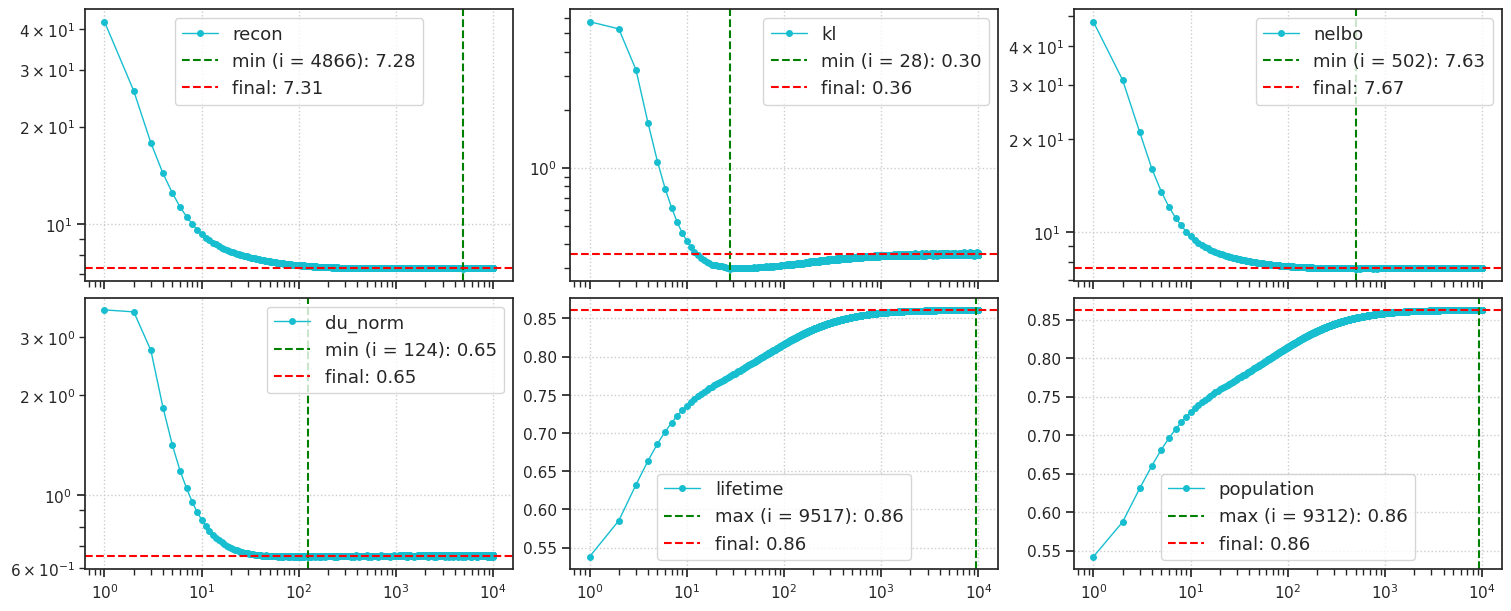

In [17]:
colors = {'trn': 'C9', 'vld': 'C0', 'tst': 'k'}
for name, d in results.items():
    if name != 'trn':
        print('\n\n\n')
    print('_' * 110)
    print('-' * 110)
    print(name)

    plot_convergence(d, color=colors[name])

### Generate

In [19]:
n_samples = 64
tr.model.reset_state(n_samples)
tr.model.update_pred(temp=0.0)
pred = tr.model.pred

output = tr.model.generate(pred, seq=range(300))
output = output.stack()

loss_kl = tonp(torch.sum(output['loss_kl'], -1))
u = tr.model.layer.log_rate.expand(n_samples, -1)
desc_len = tr.model.layer.loss_kl(u=u)
desc_len = tonp(torch.sum(desc_len, dim=-1))

list(output)

['ff', 'dist', 'samples', 'recon', 'loss_kl', 'loss_recon']

In [22]:
shape = (tr.model.cfg.input_sz, tr.model.cfg.input_sz)

In [23]:
order = np.argsort(desc_len)[::-1]

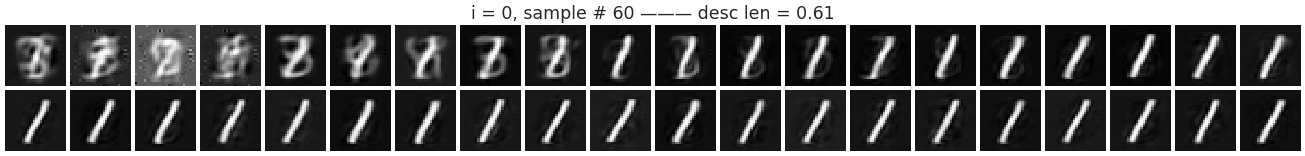

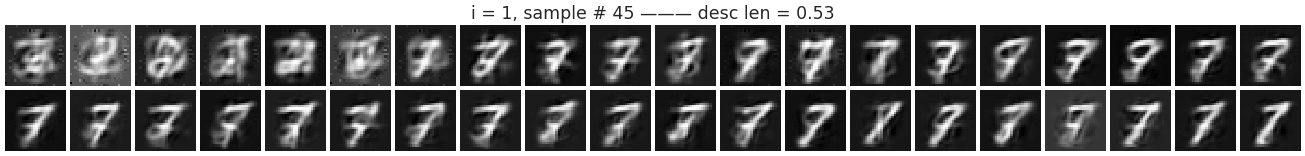

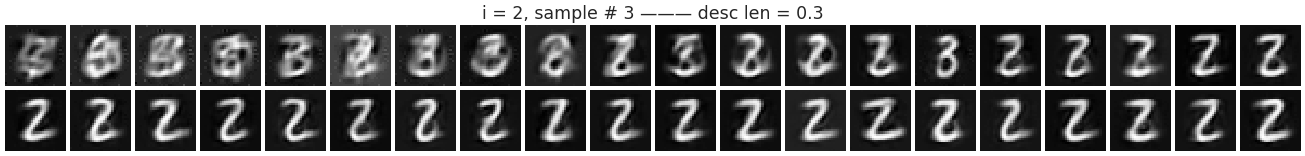

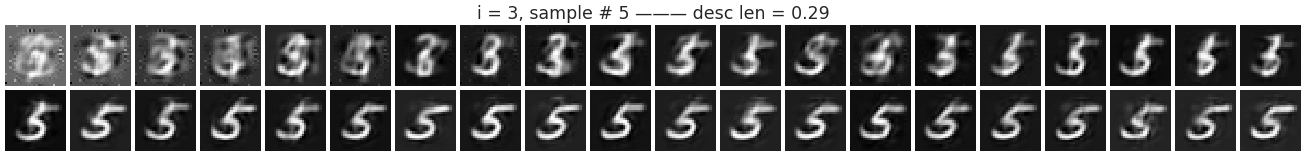

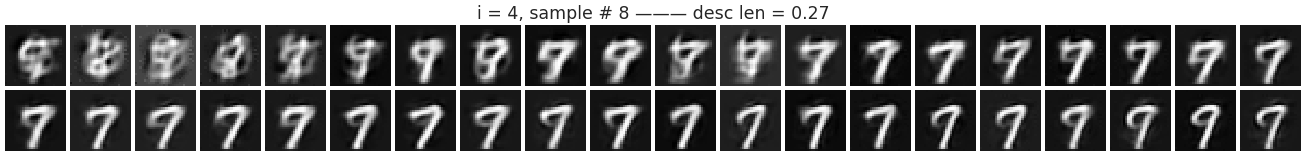

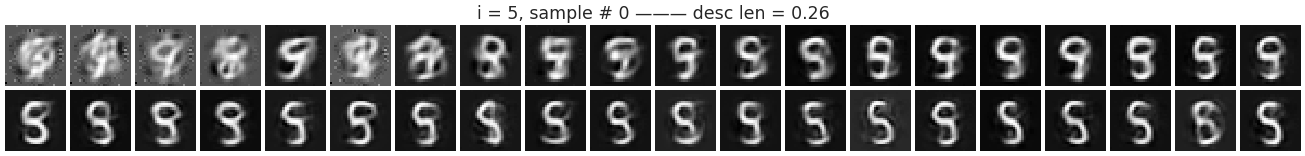

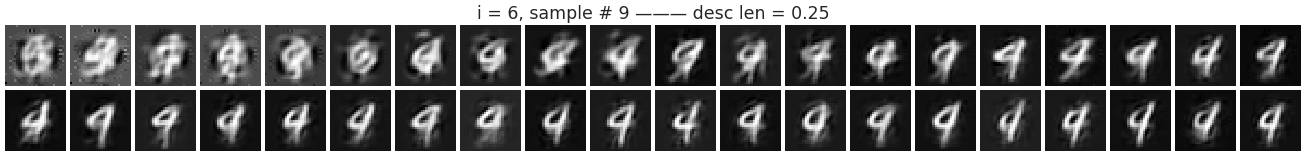

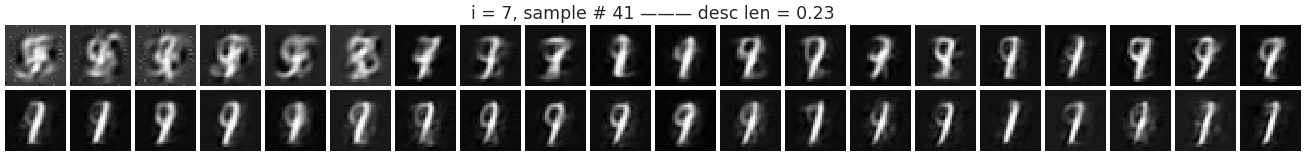

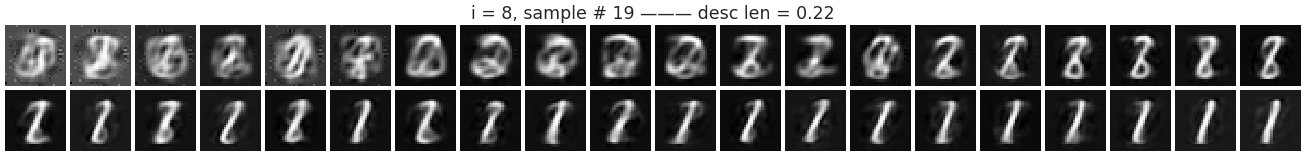

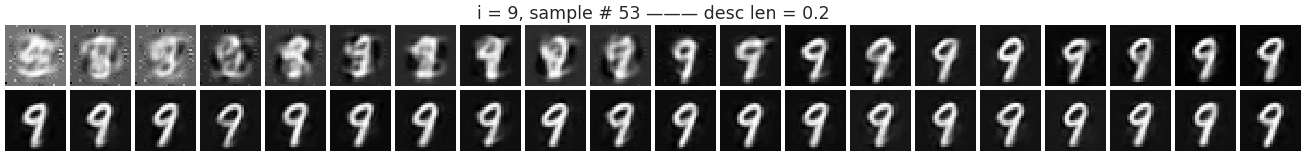

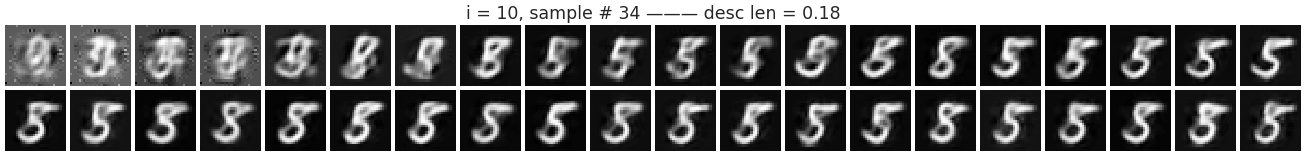

In [24]:
for i in range(len(pred)):
    if i > 10:
        continue
    sample_i = order[i]
    nrows, ncols = 2, 20
    fig, axes = create_figure(nrows, ncols, (1.3 * ncols, 1.3 * nrows), 'all', 'all', dpi=50)
    tit = ' ——— '.join([
        f"i = {i}, sample # {sample_i}",
        f"desc len = {desc_len[sample_i]:0.2g}",
    ])
    fig.suptitle(tit, fontsize=25, y=1.14)
    
    x2p = tonp(pred[sample_i].reshape(shape))
    axes[0, 0].imshow(x2p, cmap='Greys_r')
    
    for idx, ax in enumerate(axes.flat[1:], start=1):
        i, j = idx // ncols, idx % ncols
        x2p = tonp(output['recon'][sample_i, idx - 1].reshape(28, 28))
        ax.imshow(x2p, cmap='Greys_r')
    remove_ticks(axes)
    plt.show()